In [1]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle, glob
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

/home2/weiguang/.local/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home2/weiguang/.config/yt/ytrc is deprecated in favor of /home2/weiguang/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
import calc_kcor

In [3]:
SDSS_gg=np.loadtxt('data/SDSS-cluster-galaxy.txt')
SDSS_gg.shape
# 0. GroupID, 1. Group Mass [M_sun], 2. galaxyID, 3. central, 4. M* [M_sun],  5-10 mag u,g,r,i,z

(4093, 10)

In [5]:
SDSS_gg[0,6]-SDSS_gg[0,7]-calc_kcor.calc_kcor('g',0.1,'g - r',SDSS_gg[0,6]-SDSS_gg[0,7])+calc_kcor.calc_kcor('r',0.1,'g - r',SDSS_gg[0,6]-SDSS_gg[0,7])

0.716228776658587

In [4]:
# Now we do k-correct to bring 0.1color to rest-frame for SDSS  #Chilingarian & Zolotukhin 2012
SDSS_gr=np.array([SDSS_gg[i,6]-SDSS_gg[i,7]-calc_kcor.calc_kcor('g',0.1,'g - r',SDSS_gg[i,6]-SDSS_gg[i,7])+calc_kcor.calc_kcor('r',0.1,'g - r',SDSS_gg[i,6]-SDSS_gg[i,7]) 
                  for i in np.arange(SDSS_gg[:,6].size)])
SDSS_r=np.array([SDSS_gg[i,7]-calc_kcor.calc_kcor('r',0.1,'g - r',SDSS_gg[i,6]-SDSS_gg[i,7]) for i in np.arange(SDSS_gg[:,6].size)])

In [47]:
SDSS_gr,SDSS_r

(array([0.71622878, 0.69934233, 0.64073428, ..., 0.84310174, 0.81386801,
        0.79107401]),
 array([-17.08008861, -18.61821049, -18.09968133, ..., -21.99062373,
        -22.06358653, -22.2659736 ]))

In [31]:
calc_kcor.calc_kcor('r',0.1,'g - r', 0.65),calc_kcor.calc_kcor('g',0.1,'g - r', 0.65),

(0.04296635706250004, 0.12326000670000002)

# Get colors from Caesar

In [5]:
# GIZMO Get M* satellite from Caesar
if os.path.isfile('data/GZS-galaxies-info-caesar_nodust.npy'):
    GZCshr=np.load('data/GZS-galaxies-info-caesar_nodust.npy')
else:

    GIZMO=np.loadtxt("GIZMO-Mass_snap_128-center-cluster.txt")  
    GMatch=np.loadtxt('GIZMO-Matched-AHFhalo-Caesar-galaxy.txt')

    GZCshr=np.zeros((320*1000,12),dtype=np.float32)  # region, mass, central, u, g, r, i, metal, age mass-weighted, SFR, SFR_100 distance to matched center[kpc/h]

    N=0
    path='/home2/weiguang/data6/CL300_Caesar/'
    for i in np.arange(1,325):
        ds=caesar.load(path+'NewMDCLUSTER_%04d/Caesar_snap_128.hdf5'%i)
        gpos=np.array([j.minpotpos for j in ds.galaxies])  #CoM
        gmas=np.array([j.masses['stellar'] for j in ds.galaxies])
        gids=np.array([j.GroupID for j in ds.galaxies])
        su=np.array([j.absmag_nodust['sdss_u'] for j in ds.galaxies]) 
        sg=np.array([j.absmag_nodust['sdss_g'] for j in ds.galaxies]) 
        sr=np.array([j.absmag_nodust['sdss_r'] for j in ds.galaxies]) 
        si=np.array([j.absmag_nodust['sdss_i'] for j in ds.galaxies])
        sfr=np.array([j.sfr for j in ds.galaxies])
        sfr100=np.array([j.sfr_100 for j in ds.galaxies])
        met=np.array([j.metallicities['mass_weighted'] for j in ds.galaxies]) 
        age=np.array([j.ages['mass_weighted'] for j in ds.galaxies]) 
        dist=np.linalg.norm(gpos*0.6777-GIZMO[i-1,4:7],axis=1)

        ids=np.where(dist<=GIZMO[i-1,7])[0]
        n2=len(ids)

        cent=np.zeros(n2,dtype=np.int32)
        cent[gids[ids]==np.int32(GMatch[i-1,3]+0.1)]=1
        GZCshr[N:N+n2,0] = i
        GZCshr[N:N+n2,1] = gmas[ids]
        GZCshr[N:N+n2,2] = cent  # redefine the central to matched central galaxy 
        GZCshr[N:N+n2,3] = su[ids]
        GZCshr[N:N+n2,4] = sg[ids]
        GZCshr[N:N+n2,5] = sr[ids]
        GZCshr[N:N+n2,6] = si[ids]
        GZCshr[N:N+n2,7] = met[ids]
        GZCshr[N:N+n2,8] = age[ids]
        GZCshr[N:N+n2,9] = sfr[ids]
        GZCshr[N:N+n2,10] = sfr100[ids]
        GZCshr[N:N+n2,11] = dist[ids]
        N+=n2

    GZCshr=GZCshr[:N]
    np.save('data/GZS-galaxies-info-caesar_nodust',GZCshr)

In [106]:
ds.galaxies[0].info()

{'GroupID': 0,
 'L_FIR': unyt_quantity(0., 'Lsun'),
 'absmag': {'2mass_h': -25.44860076904297,
            '2mass_j': -25.209108352661133,
            '2mass_ks': -25.208755493164062,
            'b': -23.01603889465332,
            'bessell_l': -24.493091583251953,
            'bessell_lp': -24.37005615234375,
            'bessell_m': -23.887710571289062,
            'buser_b': -23.092750549316406,
            'cfht_b': -23.126909255981445,
            'cfht_i': -24.716093063354492,
            'cfht_r': -24.262189865112305,
            'cousins_i': -24.658740997314453,
            'cousins_r': -24.25831413269043,
            'des_g': -23.420934677124023,
            'des_i': -24.608171463012695,
            'des_r': -24.191404342651367,
            'des_y': -25.078224182128906,
            'des_z': -24.94365882873535,
            'fors_r': -24.25383758544922,
            'fors_v': -23.87991714477539,
            'galex_fuv': -15.527471542358398,
            'galex_nuv': -17.939439773

In [6]:
# GadgetX
if os.path.isfile('data/G3X-galaxies-info-caesar.npy'):
    GXCshr=np.load('data/G3X-galaxies-info-caesar.npy')
else:
    G3X=np.loadtxt("../Halo_mass_function_mass-difference/G3X_Mass_snap_128-center-cluster.txt")  
    XMatch=np.loadtxt('G3X-Matched-AHFhalo-Caesar-galaxy.txt')

    GXCshr=np.zeros((320*1000,12),dtype=np.float32)

    N=0
    path='/home2/weiguang/data6/G3X_Caesar/'
    for i in np.arange(1,325):
        ds=caesar.load(path+'NewMDCLUSTER_%04d/Caesar_snap_128.hdf5'%i)
        gpos=np.array([j.pos for j in ds.galaxies])  #CoM
        gmas=np.array([j.masses['stellar'] for j in ds.galaxies])  #CoM
        gids=np.array([j.GroupID for j in ds.galaxies])
        su=np.array([j.absmag['sdss_u'] for j in ds.galaxies]) 
        sg=np.array([j.absmag['sdss_g'] for j in ds.galaxies]) 
        sr=np.array([j.absmag['sdss_r'] for j in ds.galaxies]) 
        si=np.array([j.absmag['sdss_i'] for j in ds.galaxies])
        sfr=np.array([j.sfr for j in ds.galaxies])
        sfr100=np.array([j.sfr_100 for j in ds.galaxies])
        met=np.array([j.metallicities['mass_weighted'] for j in ds.galaxies]) 
        age=np.array([j.ages['mass_weighted'] for j in ds.galaxies]) 
        dist=np.linalg.norm(gpos*0.6777-G3X[i-1,3:6],axis=1)

        ids=np.where(dist<=G3X[i-1,6])[0]
        n2=len(ids)

        cent=np.zeros(n2,dtype=np.int32)
        cent[gids[ids]==np.int32(XMatch[i-1,3]+0.1)]=1
        GXCshr[N:N+n2,0] = i
        GXCshr[N:N+n2,1] = gmas[ids]
        GXCshr[N:N+n2,2] = cent
        GXCshr[N:N+n2,3] = su[ids]
        GXCshr[N:N+n2,4] = sg[ids]
        GXCshr[N:N+n2,5] = sr[ids]
        GXCshr[N:N+n2,6] = si[ids]
        GXCshr[N:N+n2,7] = met[ids]
        GXCshr[N:N+n2,8] = age[ids]
        GXCshr[N:N+n2,9] = sfr[ids]
        GXCshr[N:N+n2,10] = sfr100[ids]
        GXCshr[N:N+n2,11] = dist[ids]
        N+=n2

    GXCshr=GXCshr[:N]
    np.save('data/G3X-galaxies-info-caesar',GXCshr)

Text(0.5, 1.0, 'GIZMO')

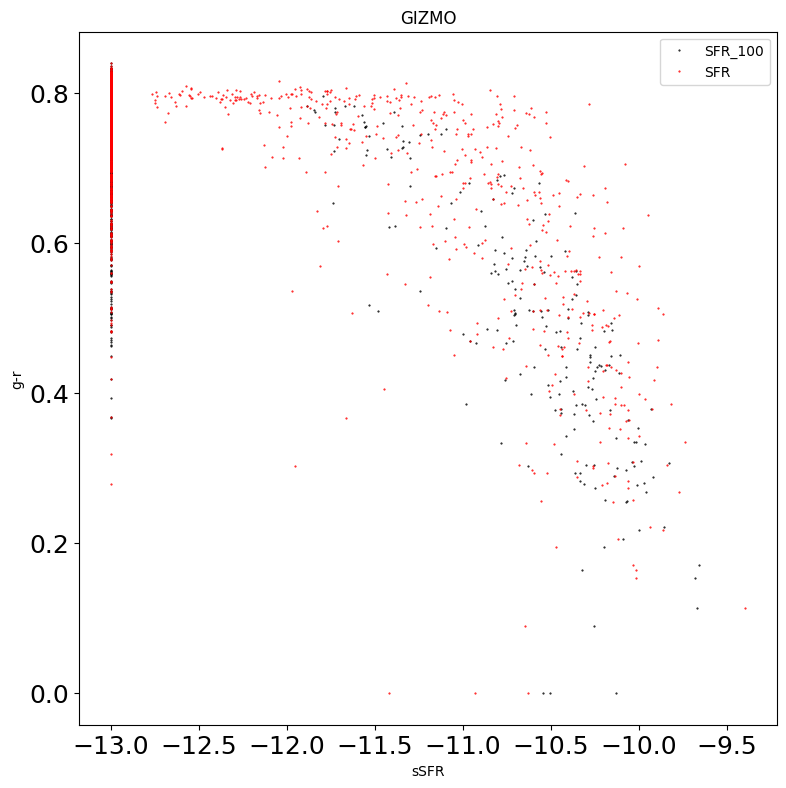

In [11]:
#Check SFR vs g-r color
fig=figure(figsize=(9,9))
ids=(GZCshr[:,1]>5e10)
plot(np.log10(GZCshr[ids,10]/GZCshr[ids,1]+1.0e-13),GZCshr[ids,4]- GZCshr[ids,5],'k.',ms=1, label='SFR_100')
plot(np.log10(GZCshr[ids,9]/GZCshr[ids,1]+1.0e-13),GZCshr[ids,4]- GZCshr[ids,5],'r.',ms=1, label='SFR')
legend()
xlabel('sSFR')
ylabel('g-r')
title('GIZMO')

Text(0.5, 1.0, 'G3X')

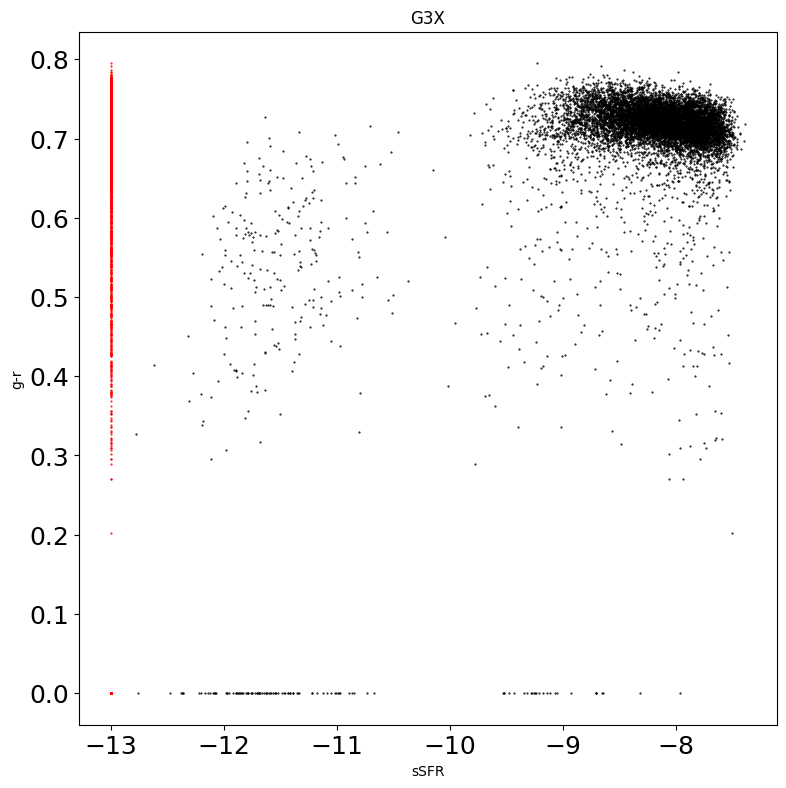

In [12]:
#Check SFR vs g-r color G3X
fig=figure(figsize=(9,9))
ids=(GXCshr[:,1]>5e10)
plot(np.log10(GXCshr[ids,10]/GXCshr[ids,1]+1.0e-13),GXCshr[ids,4]- GXCshr[ids,5],'k.',ms=1)
plot(np.log10(GXCshr[ids,9]/GXCshr[ids,1]+1.0e-13),GXCshr[ids,4]- GXCshr[ids,5],'r.',ms=1)
xlabel('sSFR')
ylabel('g-r')
title('G3X')

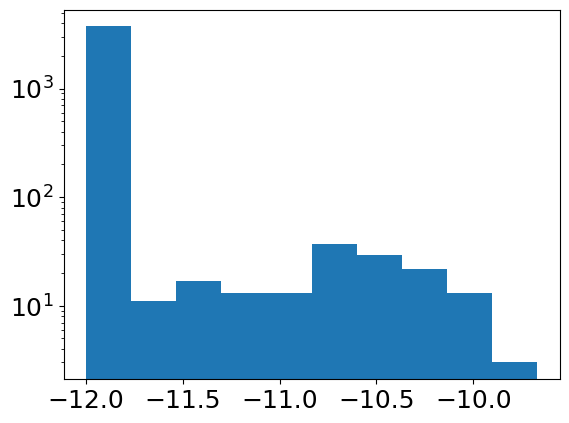

In [80]:
ids=(GZCshr[:,1]>1e11)
hist(np.log10(GZCshr[ids,10]/GZCshr[ids,1]+1.0e-12),bins=10)
yscale('log')

In [8]:
# load Semi galaxies
Galc=np.load("../optical/Galc_Satellite.npy") #HostHaloIDID(1) MainHaloID(2) Region ID(3) Mvir(4) M_star(5) mag  'g','i','r','u','z' dist in r200
Sag =np.load("../optical/Sag_Satellite.npy")

In [17]:
Galc[Galc[:,1]<=0].shape, Sag[Sag[:,1]<=0].shape, 

((324, 11), (324, 11))

In [15]:
from scipy.ndimage import gaussian_filter
from scipy import interpolate

def percentile_levels(Hg, levels):
    '''
    Hg must be normalized with Hg/=Hg.sum(). It is not normalized at here
    Levels must be in an array and <= 1
    '''
    n = 1000
    t = np.linspace(0, Hg.max(), n)
    integral = ((Hg >= t[:, None, None]) * Hg).sum(axis=(1,2))

    f = interpolate.interp1d(integral, t,bounds_error=False,fill_value=(Hg.max(),0))
    return f(levels)

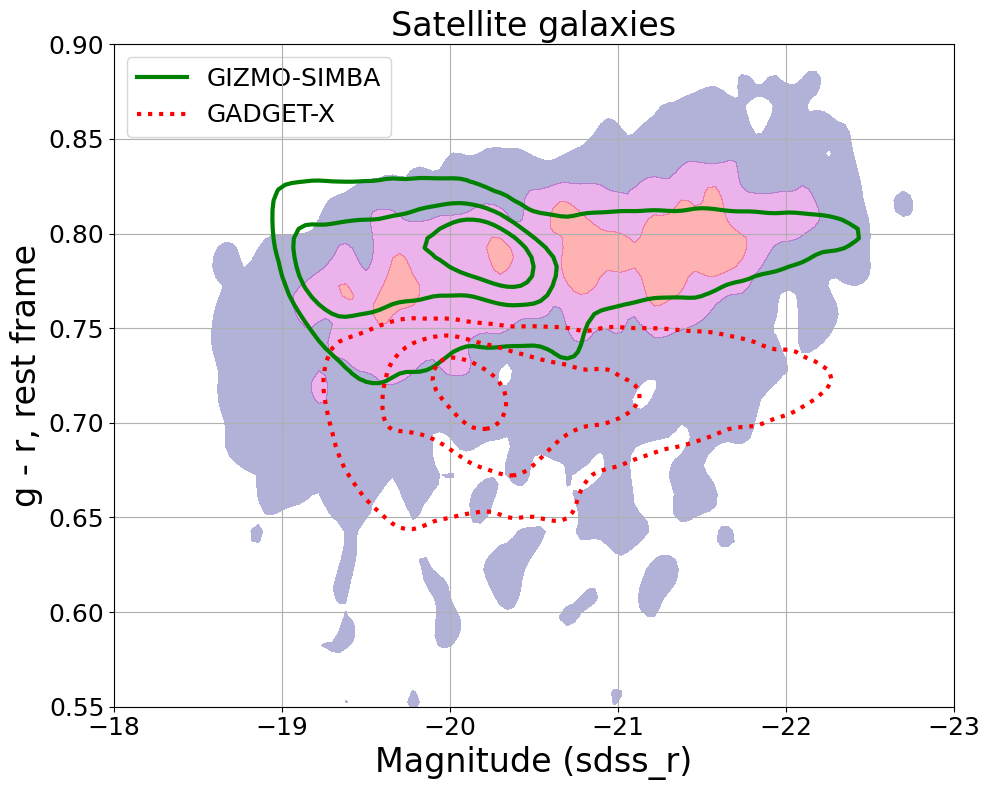

In [16]:
# satellite galaxies
fig=figure(figsize=(10,8))
# subplots(111,constrained_layout=True)
c = ('#000080', 'm','#ff0000', '#ffff00', 'c','#0000FF')

# X1 = np.arange(-24.0, -16, 0.01); xx1=(X1[1:]+X1[:-1])/2
# Y2= np.arange(0.5, 1., 0.001); yy2=(Y2[1:]+Y2[:-1])/2
X1 = np.arange(-23.0, -18, 0.04); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0.5, 1.1, 0.005); yy2=(Y2[1:]+Y2[:-1])/2

# idy=(yg[:,0]>9)&(yg[:,3]>-40)
# Hg,xe,ye = np.histogram2d(yg[idy,3]+5*np.log10(0.7),yg[idy,2]-yg[idy,3],bins=(X1,Y2),normed=True)
idy=(SDSS_gg[:,4]>1e10)&(SDSS_gg[:,7]>-40)&(SDSS_gg[:,3]!=1)
# Hg,xe,ye = np.histogram2d(SDSS_gg[idy,7],(SDSS_gg[idy,6]-SDSS_gg[idy,7]+0.08648)/1.3197,bins=(X1,Y2),normed=True)
Hg,xe,ye = np.histogram2d(SDSS_r[idy],SDSS_gr[idy],bins=(X1,Y2),normed=True)
Hg = gaussian_filter(Hg,1.5)
Hg/=np.sum(Hg)
levp = percentile_levels(Hg,np.array([0.84,0.5,0.16,0.0]))
CS=contourf(xx1, yy2, Hg.T,levp,colors=c, alpha=0.3,zorder=-9,origin = 'lower')

ids=(GZCshr[:,1]>1e10)&(GZCshr[:,2]!=1)
Hs,xe,ye = np.histogram2d(GZCshr[ids,5],GZCshr[ids,4]- GZCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=contour(xx1, yy2, Hs.T,levp,  colors='g',linewidths=3, linestyles='-',origin = 'lower')

# subplot(122)
ids=(GXCshr[:,1]>1e10)&(GXCshr[:,2]!=1)
Hs,xe,ye = np.histogram2d(GXCshr[ids,5],GXCshr[ids,4]- GXCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=contour(xx1, yy2, Hs.T, levp,colors='r', linewidths=3, linestyles=':',origin = 'lower')

#Semi galaxies
# idg=(Galc[:,4]>1.0e10)&(Galc[:,1]>0)
# Hg,xe,ye = np.histogram2d(Galc[idg,7],Galc[idg,5]-Galc[idg,7],bins=(X1,Y2),normed=True)
# Hg = gaussian_filter(Hg,1.5)
# Hg/=np.sum(Hg)
# levp = percentile_levels(Hg,np.array([0.84,0.5,0.16,0.0]))
# CS=contour(xx1, yy2, Hg.T, levp, colors='k', linewidths=0.5, linestyles='--',origin = 'lower')

# ida = (Sag[:,4]>1.0e10)&(Sag[:,1]>0)
# Hs,xe,ye = np.histogram2d(Sag[ida,7],Sag[ida,5]-Sag[ida,7],bins=(X1,Y2),normed=True)
# Hs = gaussian_filter(Hs,1.5)
# Hs/=np.sum(Hs)
# levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
# CS=contour(xx1, yy2, Hs.T, levp, colors='c', linewidths=0.5, linestyles='dashdot',origin = 'lower')

grid()

plot([],[],'g-', linewidth=3,label='GIZMO-SIMBA')
plot([],[],'r:', linewidth=3,label='GADGET-X')
# plot([],[],'k--', linewidth=0.5,label='GALACTICUS')
# plot([],[],'c-.', linewidth=0.5,label='SAG')

# tight_layout()
l=legend(loc=2,fontsize=18, markerscale=5)
l.zorder=-9
xlim(-18,-23)
ylim(0.55,0.9)
title('Satellite galaxies',fontsize=24)
xlabel('Magnitude (sdss_r)', fontsize=24)
ylabel('g - r, rest frame', fontsize=24)
tight_layout()
savefig('plots/color_mag_sate.pdf',dpi=300)

# check quenched fractions

In [12]:
gids=np.unique(np.int32(SDSS_gg[:,0]))
sdss_fq_7=np.zeros(len(gids))
sdss_fq_6=np.zeros(len(gids))
n=0
for i in gids:
    idy=(SDSS_gg[:,0]==i)&(SDSS_gg[:,4]>1e10)&(SDSS_gg[:,7]>-40)&(SDSS_gg[:,3]!=1)
    idq7=SDSS_gr[idy]>0.75
    idq6=SDSS_gr[idy]>0.65
    sdss_fq_7[n]=len(SDSS_gr[idy][idq7])/len(SDSS_gr[idy])
    sdss_fq_6[n]=len(SDSS_gr[idy][idq6])/len(SDSS_gr[idy])
    n+=1
#     print(i, len(SDSS_gr[idy][idq])/len(SDSS_gr[idy]))
# Hg,xe,ye = np.histogram2d(SDSS_gg[idy,7],(SDSS_gg[idy,6]-SDSS_gg[idy,7]+0.08648)/1.3197,bins=(X1,Y2),normed=True)
# Hg,xe,ye = np.histogram2d(SDSS_r[idy],SDSS_gr[idy],bins=(X1,Y2),normed=True)

In [100]:
len(gids)

85

In [13]:
fq_7=np.zeros(324)
fq_6=np.zeros(324)
for i in range(324):
    ids=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)
    idq7=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)&((GZCshr[:,4]- GZCshr[:,5])>0.75) #(GZCshr[:,9]/GZCshr[:,1]<1.0e-11)
    idq6=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)&((GZCshr[:,4]- GZCshr[:,5])>0.65) 
    fq_7[i]=len(GZCshr[idq7,0])/len(GZCshr[ids,0])
    fq_6[i]=len(GZCshr[idq6,0])/len(GZCshr[ids,0])

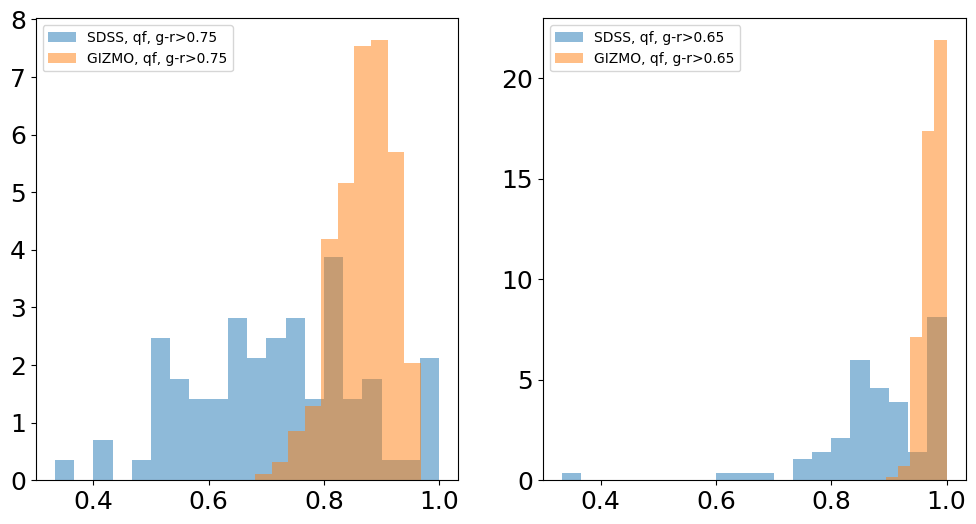

In [110]:
fig=figure(figsize=(12,6))
subplot(121)
hist(sdss_fq_7,bins=20,density=True, label='SDSS, qf, g-r>0.75', alpha=0.5)
hist(fq_7,bins=10,density=True, label='GIZMO, qf, g-r>0.75', alpha=0.5)
legend()
subplot(122)
hist(sdss_fq_6,bins=20,density=True, label='SDSS, qf, g-r>0.65', alpha=0.5)
hist(fq_6,bins=5,density=True, label='GIZMO, qf, g-r>0.65', alpha=0.5)
legend()

In [ ]:
fig=figure(figsize=(12,12))
# subplot(121)

X1= np.arange(0.2, 0.5, 0.01); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(1.9, 2.9, 0.05); yy2=(Y2[1:]+Y2[:-1])/2

ids=GZCshr[:,1]>1e10
Hs,xe,ye = np.histogram2d(GZCshr[ids,5]-GZCshr[ids,6],GZCshr[ids,3]- GZCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
# imshow(Hs.T, origin='lower')
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.06]))
CS=contour(xx1, yy2, Hs.T, levp, linewidths=1, linestyles=':', label='GIZMO')

# subplot(122)
ids=GXCshr[:,1]>1e10
Hs,xe,ye = np.histogram2d(GXCshr[ids,5]-GXCshr[ids,6],GXCshr[ids,3]- GXCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.06]))
CS=contour(xx1, yy2, Hs.T, levp, linewidths=1, linestyles='-', label='GADGET-X')
grid()
legend()
xlabel('r - i', fontsize=24)
ylabel('u - r', fontsize=24)

In [18]:
#RBH {Roche}, Nathan and {Bernardi}, Mariangela and {Hyde}, Joseph 2010 C4 BCG
c4bcg=np.array([
[-21.250862068965517, 0.7867961165048543],
[-21.75, 0.7918723994452149],
[-22.249137931034483, 0.7885436893203883],
[-22.748275862068965, 0.7991123439667128],
[-23.247413793103448, 0.7945353675450763],
[-23.749137931034483, 0.7917891816920942],
[-24.248275862068965, 0.8049375866851595],
[-21.250862068965517, 0.7779750346740638],
[-21.75, 0.7763106796116505],
[-22.249137931034483, 0.7820527045769764],
[-22.750862068965517, 0.7931206657420249],
[-23.25, 0.7889597780859916],
[-23.749137931034483, 0.786879334257975],
[-24.248275862068965, 0.7899583911234396],
[-21.250862068965517, 0.7691539528432733],
[-21.75, 0.760499306518724],
[-22.249137931034483, 0.7754785020804438],
[-22.750862068965517, 0.787128987517337],
[-23.25, 0.7833841886269071],
[-23.74913793103448, 0.7817198335644937],
[-24.24827586206896, 0.7750624133148405]])
c4bcg=c4bcg.reshape(3,7,2)
c4bcg_redo=np.zeros((7,4))
c4bcg_redo[:,0]=c4bcg[1,:,0]
c4bcg_redo[:,1]=c4bcg[0,:,1]  #upper error
c4bcg_redo[:,2]=c4bcg[1,:,1]  #mean value
c4bcg_redo[:,3]=c4bcg[2,:,1]  # lower error
c4bcg_redo

array([[-21.25086207,   0.78679612,   0.77797503,   0.76915395],
       [-21.75      ,   0.7918724 ,   0.77631068,   0.76049931],
       [-22.24913793,   0.78854369,   0.7820527 ,   0.7754785 ],
       [-22.75086207,   0.79911234,   0.79312067,   0.78712899],
       [-23.25      ,   0.79453537,   0.78895978,   0.78338419],
       [-23.74913793,   0.79178918,   0.78687933,   0.78171983],
       [-24.24827586,   0.80493759,   0.78995839,   0.77506241]])

In [19]:
#RBH max BCG
maxbcg=np.array([
[-21.250862068965517, 0.8259916782246879],
[-21.75, 0.7913730929264909],
[-22.249137931034483, 0.7733148404993064],
[-22.750862068965517, 0.7758113730929265],
[-23.25, 0.7777253814147018],
[-23.74913793103448, 0.7850485436893203],
[-24.248275862068965, 0.7892926490984743],
[-24.749999999999996, 0.8002773925104022],
[-21.250862068965517, 0.8088488210818308],
[-21.75, 0.785880721220527],
[-22.249137931034483, 0.7709847434119279],
[-22.748275862068965, 0.7740638002773925],
[-23.25, 0.7757281553398058],
[-23.749137931034483, 0.7813869625520111],
[-24.24827586206896, 0.7834674063800277],
[-24.749999999999996, 0.8002773925104021],
[-21.250862068965517, 0.7916227461858529],
[-21.75, 0.780388349514563],
[-22.249137931034483, 0.7698196948682385],
[-22.750862068965517, 0.7728155339805824],
[-23.25, 0.7742302357836338],
[-23.74913793103448, 0.7790568654646324],
[-24.248275862068965, 0.7778085991678224],
[-24.749999999999996, 0.8002773925104021]
])
maxbcg_redo=np.zeros((8,4))
maxbcg_redo[:,0]=maxbcg[8:16,0]
maxbcg_redo[:,1]=maxbcg[0:8,1]  #upper error
maxbcg_redo[:,2]=maxbcg[8:16,1]  #mean value
maxbcg_redo[:,3]=maxbcg[16:24,1]  # lower error
maxbcg_redo

array([[-21.25086207,   0.82599168,   0.80884882,   0.79162275],
       [-21.75      ,   0.79137309,   0.78588072,   0.78038835],
       [-22.24913793,   0.77331484,   0.77098474,   0.76981969],
       [-22.74827586,   0.77581137,   0.7740638 ,   0.77281553],
       [-23.25      ,   0.77772538,   0.77572816,   0.77423024],
       [-23.74913793,   0.78504854,   0.78138696,   0.77905687],
       [-24.24827586,   0.78929265,   0.78346741,   0.7778086 ],
       [-24.75      ,   0.80027739,   0.80027739,   0.80027739]])

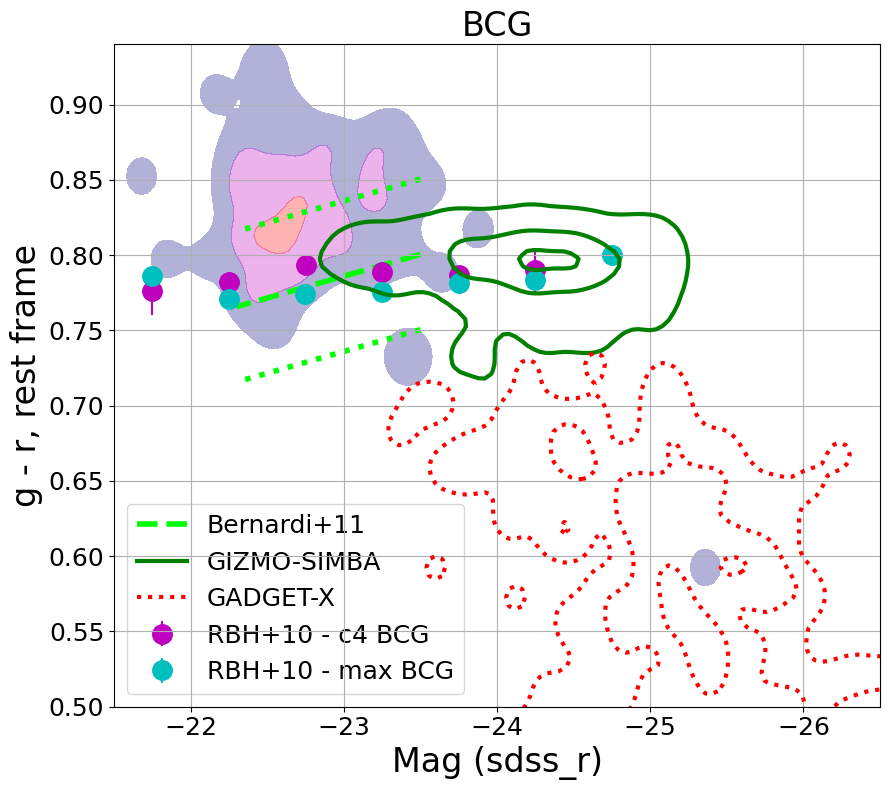

In [21]:
# for BCG
fig=figure(figsize=(9,8))
# subplot(121)
c = ('#000080', 'm','#ff0000', '#ffff00', 'c','#0000FF')

# X1 = np.arange(-24.0, -16, 0.01); xx1=(X1[1:]+X1[:-1])/2
# Y2= np.arange(0.5, 1., 0.001); yy2=(Y2[1:]+Y2[:-1])/2
X1 = np.arange(-27.5, -21, 0.04); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0.3, 1.2, 0.005); yy2=(Y2[1:]+Y2[:-1])/2

idy=(SDSS_gg[:,4]>1e10)&(SDSS_gg[:,7]>-40)&(SDSS_gg[:,3]==1)
# Hg,xe,ye = np.histogram2d(SDSS_gg[idy,7],(SDSS_gg[idy,6]-SDSS_gg[idy,7]+0.08648)/1.3197,bins=(X1,Y2),normed=True)
Hg,xe,ye = np.histogram2d(SDSS_r[idy],SDSS_gr[idy],bins=(X1,Y2),normed=True)
Hg = gaussian_filter(Hg,2.5)
Hg/=np.sum(Hg)
levp = percentile_levels(Hg,np.array([0.9,0.5,0.1,0.0]))
CS=contourf(xx1, yy2, Hg.T,levp,colors=c, alpha=0.3,zorder=-9,origin = 'lower')

ids=(GZCshr[:,1]>1e10)&(GZCshr[:,2]==1)
Hs,xe,ye = np.histogram2d(GZCshr[ids,5],GZCshr[ids,4]- GZCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,2.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.9,0.5,0.1,0.0]))
CS=contour(xx1, yy2, Hs.T,levp,  colors='g',linewidths=3, linestyles='-',origin = 'lower')

ids=(GXCshr[:,1]>1e10)&(GXCshr[:,2]==1)
Hs,xe,ye = np.histogram2d(GXCshr[ids,5],GXCshr[ids,4]- GXCshr[ids,5],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,2.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.9,0.5,0.1,0.0]))
CS=contour(xx1, yy2, Hs.T, levp,colors='r', linewidths=3, linestyles=':',origin = 'lower')

# #Semi galaxies
# idg=(Galc[:,4]>1.0e10)&(Galc[:,1]<=0)
# Hg,xe,ye = np.histogram2d(Galc[idg,7],Galc[idg,5]-Galc[idg,7],bins=(X1,Y2),normed=True)
# Hg = gaussian_filter(Hg,1.5)
# Hg/=np.sum(Hg)
# levp = percentile_levels(Hg,np.array([0.9,0.5,0.1,0.0]))
# CS=contour(xx1, yy2, Hg.T, levp, colors='k', linewidths=0.5, linestyles='--',origin = 'lower')

# ida = (Sag[:,4]>1.0e10)&(Sag[:,1]<=0)
# Hs,xe,ye = np.histogram2d(Sag[ida,7],Sag[ida,5]-Sag[ida,7],bins=(X1,Y2),normed=True)
# Hs = gaussian_filter(Hs,1.5)
# Hs/=np.sum(Hs)
# levp = percentile_levels(Hs,np.array([0.9,0.5,0.1,0.0]))
# CS=contour(xx1, yy2, Hs.T, levp, colors='c', linewidths=0.5, linestyles='dashdot',origin = 'lower')


#observation data
errorbar(c4bcg_redo[:,0],c4bcg_redo[:,2], yerr=np.array([c4bcg_redo[:,2]-c4bcg_redo[:,3], c4bcg_redo[:,1]-c4bcg_redo[:,2]]),
              fmt='o',c='m',mec='m',zorder=-9, ms=14, label='RBH+10 - c4 BCG')
errorbar(maxbcg_redo[:,0],maxbcg_redo[:,2], yerr=np.array([maxbcg_redo[:,2]-maxbcg_redo[:,3], maxbcg_redo[:,1]-maxbcg_redo[:,2]]),
              fmt='o',c='c',mec='c',zorder=-9, ms=14, label='RBH+10 - max BCG')

# Bernardi et al. 2011
# −22 < Mr < −20.75 −0.019 ± 0.001 0.361 ± 0.013
# −23.5 < Mr < −22.25 −0.029 ± 0.001 0.119 ± 0.027
x=np.arange(-23.5,-22.25,0.1)
plot(x,-0.029*x+0.119,'--',color='lime',lw=4,label='Bernardi+11',zorder=-9)
plot(x,-0.029*x+0.119+0.05,':',color='lime',lw=4,zorder=-9)
plot(x,-0.029*x+0.119-0.05,':',color='lime',lw=4,zorder=-9)
# x=np.arange(-22.25,-20.75,0.1)
# plot(x,-0.019*x+0.361,'k-')
# plot(x,-0.019*x+0.361+0.05,'k--')
# plot(x,-0.019*x+0.361-0.05,'k--')

grid()

plot([],[],'g-', linewidth=3,label='GIZMO-SIMBA')
plot([],[],'r:', linewidth=3,label='GADGET-X')
# plot([],[],'k--', linewidth=0.5,label='GALACTICUS')
# plot([],[],'c-.', linewidth=0.5,label='SAG')

tight_layout()
l=legend(loc=3,fontsize=18, markerscale=1)
l.zorder=-9
xlim(-21.5,-26.5)
ylim(0.5,0.94)
title('BCG',fontsize=24)
xlabel('Mag (sdss_r)', fontsize=24)
ylabel('g - r, rest frame', fontsize=24)
tight_layout()
savefig('plots/color_mag_BCG.pdf',dpi=300)

In [41]:
# idg=(Galc[:,4]>1.0e10)&(Galc[:,1]<=0)
print(int64(Galc[idg,0]+0.1))#,Sag[ida,0]
np.save('../MultiDark-Zoom/RockstarTreeRootIDs_for_300clusters',int64(Galc[idg,0]+0.1))

[12663401752 12568957065 12657871796 12690066801 12698654951 12690125164
 12636014904 12577987103 12656411108 12578986015 12705641046 12684705936
 12705594475 12638697135 12694372365 12603224585 12582721130 12668895752
 12703539678 12657874277 12672747986 12650062766 12594389661 12684570711
 12677601738 12640964729 12596343080 12615510884 12598752842 12673756788
 12579109936 12686785434 12654172216 12603902385 12640501425 12630507688
 12705008265 12581363869 12690072151 12630082804 12631840147 12675106536
 12574272137 12656156641 12600479161 12691139003 12588786834 12669699551
 12575741954 12653096587 12604967217 12587790130 12570693121 12660897460
 12596056208 12650311783 12593895209 12617271026 12639540115 12612096680
 12586929046 12614710479 12643433301 12648020319 12642510281 12595207277
 12676198032 12596377981 12587069966 12632267220 12606544584 12701135694
 12679009858 12611737724 12634646985 12691835165 12633566111 12664795164
 12695175512 12668893872 12665905350 12598970228 12

# Check matal vs age

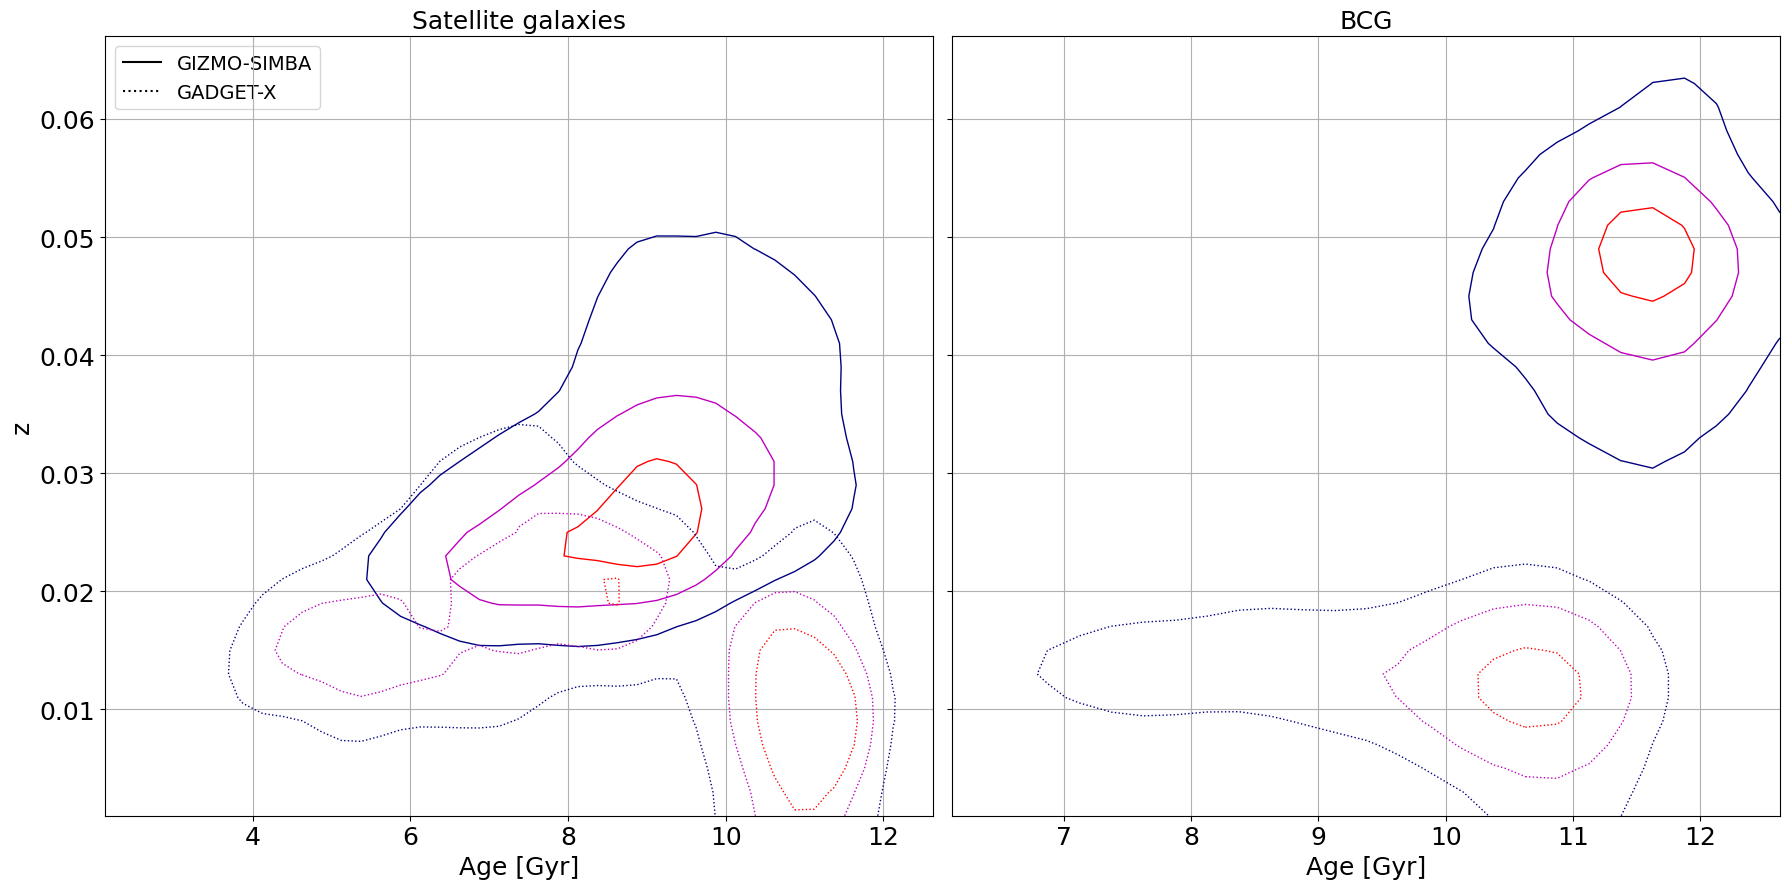

In [12]:
f, (ax1, ax2) = subplots(1, 2, sharey=True, figsize=(18,9))


X1 = np.arange(2, 13, 0.25); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0., 0.07, 0.002); yy2=(Y2[1:]+Y2[:-1])/2

ids=(GZCshr[:,1]>1e10)&(GZCshr[:,2]!=1)&(GZCshr[:,-2]>-1) &( GZCshr[:,-2]<1000)
Hs,xe,ye = np.histogram2d(GZCshr[ids,-1], GZCshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=ax1.contour(xx1, yy2, Hs.T,levp,  colors=c,linewidths=1, linestyles='-')

ids=(GXCshr[:,1]>1e10)&(GXCshr[:,2]!=1)&(GXCshr[:,-2]>-1) &( GXCshr[:,-2]<1000)
Hs,xe,ye = np.histogram2d(GXCshr[ids,-1],GXCshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=ax1.contour(xx1, yy2, Hs.T, levp,colors=c, linewidths=1, linestyles=':')
ax1.grid()

ax1.plot([],[],'k-', label='GIZMO-SIMBA')
ax1.plot([],[],'k:', label='GADGET-X')

l=ax1.legend(loc=2,fontsize=14, markerscale=5)
l.zorder=-9
ax1.set_title('Satellite galaxies',fontsize=18)
ax1.set_xlabel('Age [Gyr]', fontsize=18)
ax1.set_ylabel('z', fontsize=18)

X1 = np.arange(6, 13, 0.25); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0., 0.07, 0.002); yy2=(Y2[1:]+Y2[:-1])/2
ids=(GZCshr[:,1]>1e10)&(GZCshr[:,2]==1)&(GZCshr[:,-2]>-1) &( GZCshr[:,-2]<1000)
Hs,xe,ye = np.histogram2d(GZCshr[ids,-1], GZCshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=ax2.contour(xx1, yy2, Hs.T,levp,  colors=c,linewidths=1, linestyles='-')

ids=(GXCshr[:,1]>1e10)&(GXCshr[:,2]==1)&(GXCshr[:,-2]>-1) &( GXCshr[:,-2]<1000)
Hs,xe,ye = np.histogram2d(GXCshr[ids,-1],GXCshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=ax2.contour(xx1, yy2, Hs.T, levp,colors=c, linewidths=1, linestyles=':')
ax2.grid()
ax2.set_title('BCG',fontsize=18)
ax2.set_xlabel('Age [Gyr]', fontsize=18)
tight_layout()
f.savefig('plots/age_metal.pdf')

In [ ]:
GZCshr[(GZCshr[:,-2]>-1) &( GZCshr[:,-2]<1000),-2].min()

# Get AHF+STARDUST results

In [49]:
Xshr=np.zeros((0,15))
G3X=np.loadtxt("../Halo_mass_function_mass-difference/G3X_Mass_snap_128-center-cluster.txt")  
XHid=np.int64(G3X[:,1]+0.2)
XRid=np.int32(G3X[:,0]+0.2)
sname="/snap_128"
n=0
fpath = "/home2/weiguang/The300/data/catalogues/AHF/"
for i in np.arange(G3X.shape[0]):
    exts='0000'+str(XRid[i])
    cn = 'NewMDCLUSTER_'+exts[-4:]
    f = fpath +"GadgetX/"+ cn + "/GadgetX-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_halos"
    fl= fpath +"GadgetX/"+ cn + "/GadgetX-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_luminosities"
    fm= fpath +"GadgetX/"+ cn + "/GadgetX-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_magnitudes"    
#     if XRid[i] != n:
    tmpd = np.loadtxt(f, usecols=(0,1,2,3,64),dtype=np.float64) #ID(1) hostHalo(2) numSubStruct(3) Mvir(4) M_star(65)
    hid=np.int64(tmpd[:,0]+0.2); hhid=np.int64(tmpd[:,1]+0.2)  
    tmpl = np.loadtxt(fl, usecols=(0,14,15,16,17,18))
    tmpm = np.loadtxt(fm, usecols=(0,14,15,16,17,18),dtype=np.float64)

#     print(exts, tmpl.shape,tmpd.shape,tmpm.shape,hid.shape,hhid.shape)
    
    #M*200
    idm=(hid==XHid[i]) | (hhid==XHid[i])
    matid=np.in1d(tmpl[:,0],hid[idm])
    print(exts,len(hid[idm]),len(tmpl[matid,0]))
    if len(hid[idm])>0: #Must be
        tmod=np.zeros((len(hid[idm]),15))-1
        tmod[:,:5]=tmpd[idm]
        tmod[:,2]=XRid[i] #HID(0) hostHalo(1) RID(2) Mvir(3) M_star(4)
        n1,n2=0,0
        for j in range(len(hid[idm])):
            idm1=tmpl[:,0]==tmod[j,0]
            if len(tmpl[idm1,0])==1:
                tmod[j,5:10]=tmpl[idm1,1:] #Lum ugriz
                n1+=1
            idm2=tmpm[:,0]==tmod[j,0]
            if len(tmpm[idm2,0])==1:
                tmod[j,10:15]=tmpm[idm2,1:] #Mag ugriz
                n2+=1
#         Xshr.extend(tmod.tolist())
        Xshr=np.append(Xshr, tmod, axis=0)
        print(n1,n2)
    else:
        print("Can not find matching...",i,n,XHid[i])
# Xshr=np.asarray(Xshr)
np.save("data/G3X_AHF_STARDUST.npy",Xshr)

00001 1248 744
744 744
00002 974 638
638 638
00003 874 527
527 527
00004 925 527
527 527
00005 869 534
534 534
00006 1020 617
617 617
00007 710 465
465 465
00008 1018 579
579 579
00009 740 484
484 484
000010 718 424
424 424
000011 705 417
417 417
000012 749 449
449 449
000013 668 418
418 418
000014 654 389
389 389
000015 749 479
479 479
000016 858 477
477 477
000017 608 378
378 378
000018 587 398
398 398
000019 652 401
401 401
000020 587 357
357 357
000021 619 389
389 389
000022 420 254
254 254
000023 728 410
410 410
000024 623 388
388 388
000025 538 327
327 327
000026 674 384
384 384
000027 665 406
406 406
000028 511 322
322 322
000029 623 392
392 392
000030 617 408
408 408
000031 577 357
357 357
000032 624 389
389 389
000033 571 380
380 380
000034 634 395
395 395
000035 604 357
357 357
000036 550 365
365 365
000037 586 358
358 358
000038 313 194
194 194
000039 523 344
344 344
000040 558 324
324 324
000041 562 346
346 346
000042 566 348
348 348
000043 590 357
357 357
000044 563 351
35

In [48]:
Zshr=np.zeros((0,15))
GIZMO=np.loadtxt("GIZMO-Mass_snap_128-center-cluster.txt")  
ZHid=np.int64(GIZMO[:,1]+0.2)
ZRid=np.int32(GIZMO[:,0]+0.2)
sname="/snap_128"
n=0
fpath = "/home2/weiguang/The300/data/catalogues/AHF/"
for i in np.arange(GIZMO.shape[0]):
    exts='0000'+str(ZRid[i])
    cn = 'NewMDCLUSTER_'+exts[-4:]
    f = fpath +"GIZMO/"+ cn + "/GIZMO-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_halos"
    fl= fpath +"GIZMO/"+ cn + "/GIZMO-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_luminosities"
    fm= fpath +"GIZMO/"+ cn + "/GIZMO-NewMDCLUSTER_" +cn[-4:]+".snap_128.z0.000.AHF_magnitudes"    
    if not os.path.isfile(fl):
        print('can not find file: ',fl)
        continue
#     if XRid[i] != n:
    tmpd = np.loadtxt(f, usecols=(0,1,2,3,64),dtype=np.float64) #ID(1) hostHalo(2) numSubStruct(3) Mvir(4) M_star(65)
    hid=np.int64(tmpd[:,0]+0.2); hhid=np.int64(tmpd[:,1]+0.2)  
    tmpl = np.loadtxt(fl, usecols=(0,14,15,16,17,18))
    tmpm = np.loadtxt(fm, usecols=(0,14,15,16,17,18),dtype=np.float64)  #JOHNSON_U 14      SDSS_g 15     SDSS_i 16    SDSS_r 17     SDSS_U 18   SDSS_z 19

#     print(exts, tmpl.shape,tmpd.shape,tmpm.shape,hid.shape,hhid.shape)
    
    #M*200
    idm=(hid==ZHid[i]) | (hhid==ZHid[i])
    matid=np.in1d(tmpl[:,0],hid[idm])
    print(exts,len(hid[idm]),len(tmpl[matid,0]))
    if len(hid[idm])>0: #Must be
        tmod=np.zeros((len(hid[idm]),15))-1
        tmod[:,:5]=tmpd[idm]
        tmod[:,2]=XRid[i] #HID(0) hostHalo(1) RID(2) Mvir(3) M_star(4)
        n1,n2=0,0
        for j in range(len(hid[idm])):
            idm1=tmpl[:,0]==tmod[j,0]
            if len(tmpl[idm1,0])==1:
                tmod[j,5:10]=tmpl[idm1,1:] #Lum ugriz
                n1+=1
            idm2=tmpm[:,0]==tmod[j,0]
            if len(tmpm[idm2,0])==1:
                tmod[j,10:15]=tmpm[idm2,1:] #Mag ugriz
                n2+=1
        Zshr=np.append(Zshr, tmod, axis=0)
        print(n1,n2)
    else:
        print("Can not find matching...",i,n,XHid[i])
# Zshr=np.asarray(Zshr)
np.save("data/GIZMO_AHF_STARDUST.npy",Zshr)

00001 2156 1782
1782 1782
00002 1785 1540
1540 1540
00003 1360 1147
1147 1147
00004 1509 1250
1250 1250
00005 1621 1348
1348 1348
00006 1723 1418
1418 1418
00007 1284 1114
1114 1114
00008 1246 1050
1050 1050
00009 1325 1116
1116 1116
000010 1201 1010
1010 1010
000011 1149 979
979 979
000012 1227 1036
1036 1036
000013 1073 911
911 911
000014 1201 1004
1004 1004
000015 1217 1048
1048 1048
000016 1432 1135
1135 1135
000017 995 863
863 863
000018 1059 944
944 944
000019 1071 907
907 907
000020 949 803
803 803
000021 1044 892
892 892
000022 708 604
604 604
000023 1120 937
937 937
000024 1096 943
943 943
000025 856 709
709 709
000026 1181 987
987 987
000027 1114 925
925 925
000028 902 741
741 741
000029 1048 907
907 907
000030 1095 936
936 936
000031 990 853
853 853
000032 1106 914
914 914
000033 984 850
850 850
000034 1084 893
893 893
000035 1017 817
817 817
000036 952 833
833 833
000037 1009 870
870 870
000038 471 407
407 407
000039 935 786
786 786
000040 928 775
775 775
000041 959 810
810

In [44]:
tmod.shape

(2156, 15)

Text(94.84722222222221, 0.5, 'g - r')

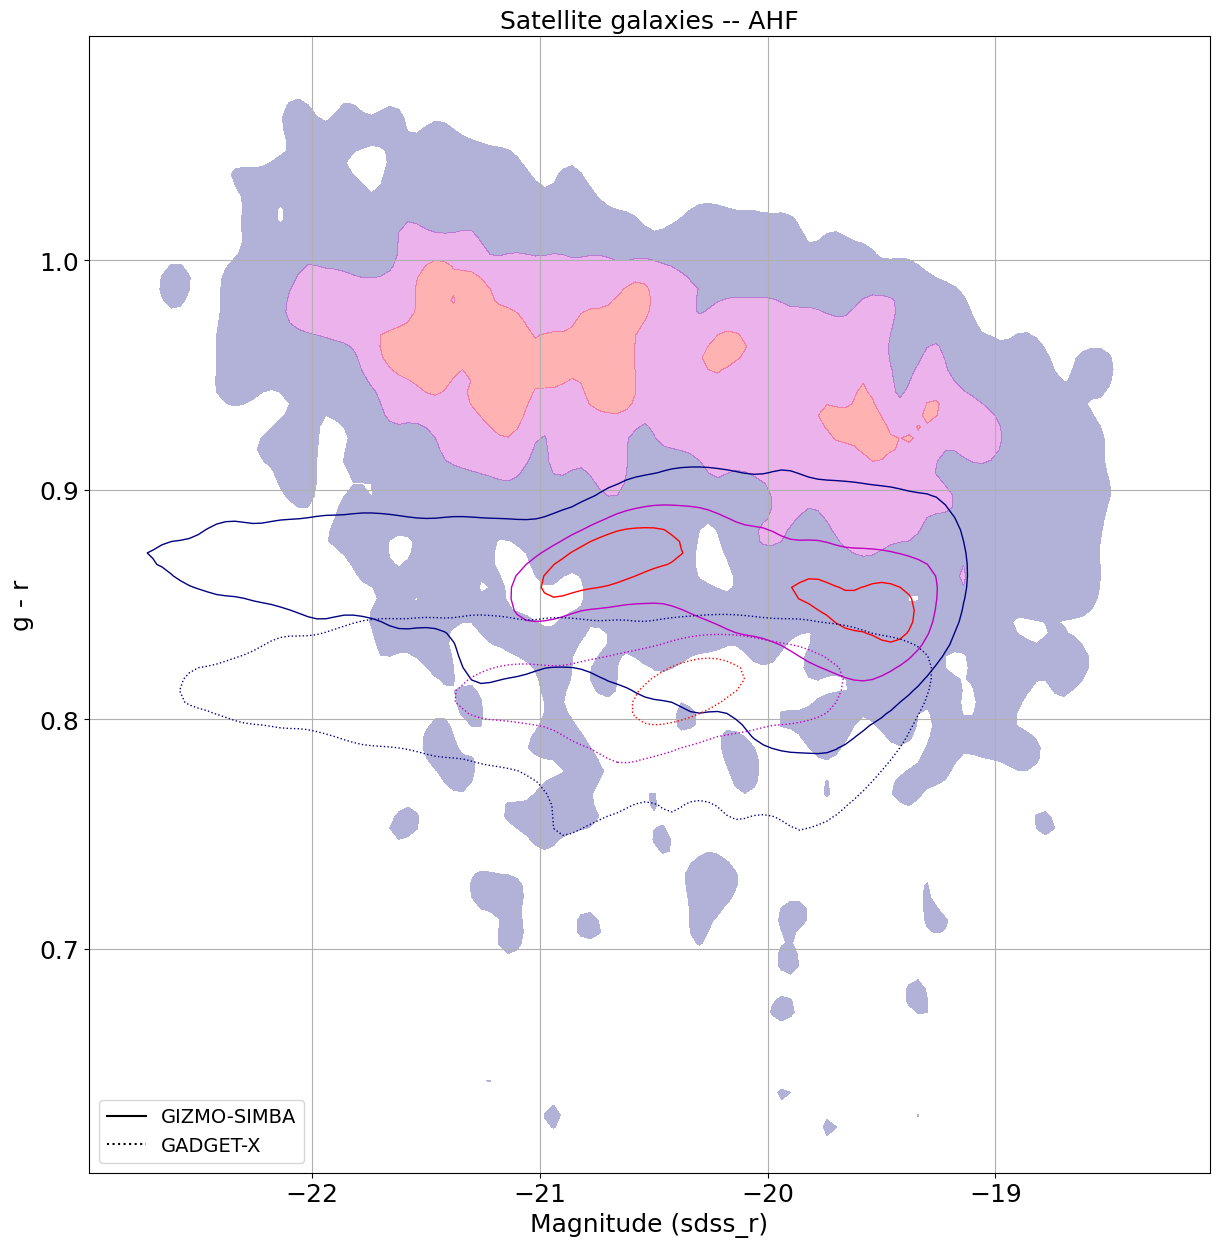

In [54]:
# Test plot # satellite galaxies
fig=figure(figsize=(12,12))
# subplot(121)
c = ('#000080', 'm','#ff0000', '#ffff00', 'c','#0000FF')

X1 = np.arange(-23.0, -18, 0.04); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0.6, 1.1, 0.005); yy2=(Y2[1:]+Y2[:-1])/2

# idy=(yg[:,0]>9)&(yg[:,3]>-40)
# Hg,xe,ye = np.histogram2d(yg[idy,3]+5*np.log10(0.7),yg[idy,2]-yg[idy,3],bins=(X1,Y2),normed=True)
idy=(SDSS_gg[:,4]>1e10)&(SDSS_gg[:,7]>-40)&(SDSS_gg[:,3]!=1)
Hg,xe,ye = np.histogram2d(SDSS_gg[idy,7],SDSS_gg[idy,6]-SDSS_gg[idy,7],bins=(X1,Y2),normed=True)
Hg = gaussian_filter(Hg,1.5)
Hg/=np.sum(Hg)
levp = percentile_levels(Hg,np.array([0.84,0.5,0.16,0.0]))
CS=contourf(xx1, yy2, Hg.T,levp,colors=c, alpha=0.3,zorder=-9)

ids=(Zshr[:,4]/0.6777>1e10)&(Zshr[:,1]>1)&(Zshr[:,5]>1)
Hs,xe,ye = np.histogram2d(Zshr[ids,-2],Zshr[ids,-4]-Zshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=contour(xx1, yy2, Hs.T,levp,  colors=c,linewidths=1, linestyles='-')

# subplot(122)
ids=(Xshr[:,4]/0.6777>1e10)&(Xshr[:,1]>1)&(Xshr[:,5]>1)
Hs,xe,ye = np.histogram2d(Xshr[ids,-2],Xshr[ids,-4]- Xshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.84,0.5,0.16,0.0]))
CS=contour(xx1, yy2, Hs.T, levp,colors=c, linewidths=1, linestyles=':')
grid()

plot([],[],'k-', label='GIZMO-SIMBA')
plot([],[],'k:', label='GADGET-X')
tight_layout()
l=legend(loc=3,fontsize=14, markerscale=5)
l.zorder=-9
title('Satellite galaxies -- AHF',fontsize=18)
xlabel('Magnitude (sdss_r)', fontsize=18)
ylabel('g - r', fontsize=18)
# savefig('plots/color_mag_sate.pdf',dpi=300)

Text(94.84722222222221, 0.5, 'g - r')

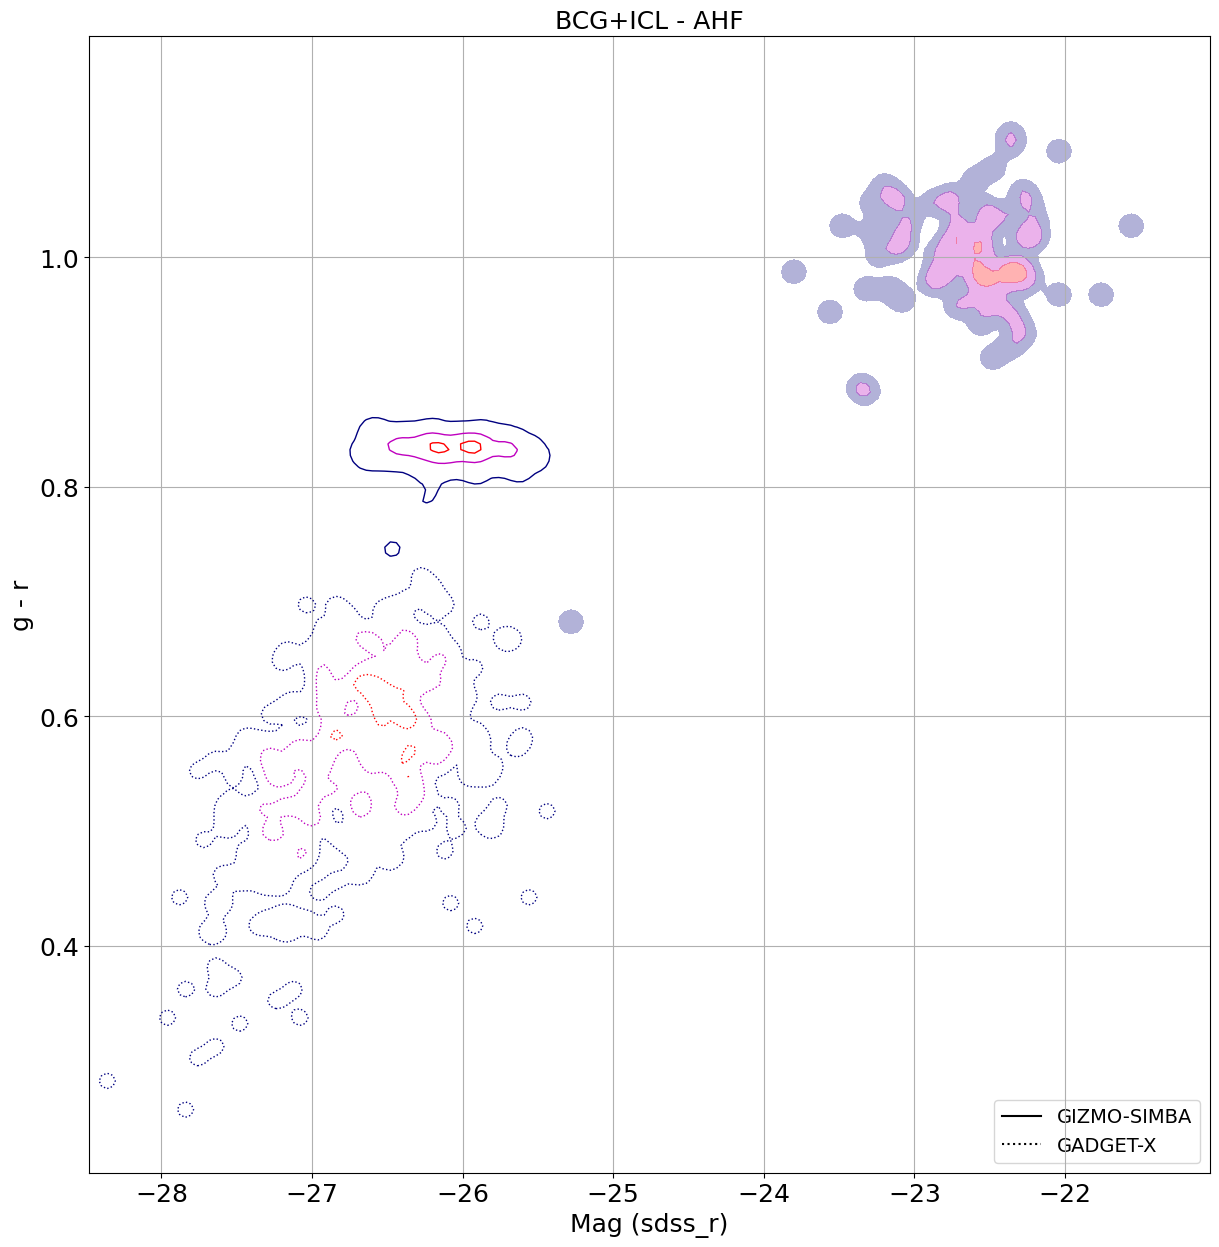

In [58]:
# for BCG
fig=figure(figsize=(12,12))
# subplot(121)
c = ('#000080', 'm','#ff0000', '#ffff00', 'c','#0000FF')

# X1 = np.arange(-24.0, -16, 0.01); xx1=(X1[1:]+X1[:-1])/2
# Y2= np.arange(0.5, 1., 0.001); yy2=(Y2[1:]+Y2[:-1])/2
X1 = np.arange(-28.5, -21, 0.04); xx1=(X1[1:]+X1[:-1])/2
Y2= np.arange(0.2, 1.2, 0.005); yy2=(Y2[1:]+Y2[:-1])/2

idy=(SDSS_gg[:,4]>1e10)&(SDSS_gg[:,7]>-40)&(SDSS_gg[:,3]==1)
Hg,xe,ye = np.histogram2d(SDSS_gg[idy,7],SDSS_gg[idy,6]-SDSS_gg[idy,7],bins=(X1,Y2),normed=True)
Hg = gaussian_filter(Hg,1.5)
Hg/=np.sum(Hg)
levp = percentile_levels(Hg,np.array([0.9,0.5,0.1,0.0]))
CS=contourf(xx1, yy2, Hg.T,levp,colors=c, alpha=0.3,zorder=-9)

ids=(Zshr[:,4]/0.6777>1e10)&(Zshr[:,1]<1)&(Zshr[:,5]>1)
Hs,xe,ye = np.histogram2d(Zshr[ids,-2],Zshr[ids,-4]-Zshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.9,0.5,0.1,0.0]))
CS=contour(xx1, yy2, Hs.T,levp,  colors=c,linewidths=1, linestyles='-')

# subplot(122)
ids=(Xshr[:,4]/0.6777>1e10)&(Xshr[:,1]<1)&(Xshr[:,5]>1)
Hs,xe,ye = np.histogram2d(Xshr[ids,-2],Xshr[ids,-4]- Xshr[ids,-2],bins=(X1,Y2),normed=True)
Hs = gaussian_filter(Hs,1.5)
Hs/=np.sum(Hs)
levp = percentile_levels(Hs,np.array([0.9,0.5,0.1,0.0]))
CS=contour(xx1, yy2, Hs.T, levp,colors=c, linewidths=1, linestyles=':')
grid()

plot([],[],'k-', label='GIZMO-SIMBA')
plot([],[],'k:', label='GADGET-X')
tight_layout()
l=legend(loc=4,fontsize=14, markerscale=5)
l.zorder=-9
title('BCG+ICL - AHF',fontsize=18)
xlabel('Mag (sdss_r)', fontsize=18)
ylabel('g - r', fontsize=18)